In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

import lightning as L
import numpy as np

from models.base.varnet_primitive import SMEBlock
from models.base.unet import NormUnet
from dataset import SliceDataModule
import fastmri
from models.varnet_rough_sens_faster import VarNetRoughSensFaster
from models.varnet_rough_sens import VarNetRoughSens
from models.varnet_logistic_sens import VarNetLogisticSens
from models.varnet_logistic_unet_sens_fix import VarNetLogisticUnetSensFix

In [2]:
# sens_chans = 8
# sens_pools = 4

# sens_net_path = "checkpoints/sens_net/for_Sens.pt"
# sens_net_state_dict = torch.load(sens_net_path)
# sens_net = SMEBlock(
#     image_processor=NormUnet(sens_chans, sens_pools)
# )

# # Replace StateDict with new keys
# keys = sens_net.state_dict().keys()
# new_state_dict = {}
# for key in keys:
#     new_state_dict[key] = sens_net_state_dict[key.replace("image_processor.", "norm_unet.")]
# sens_net.load_state_dict(new_state_dict)
# sens_net = sens_net.cuda()

In [3]:
HASH = "2afc06da58224c798b8f8c9969e696eb"
checkpoint_path = f"mlruns/0/{HASH}/artifacts/checkpoints/latest_checkpoint.pth"
checkpoint = torch.load(checkpoint_path)

model = VarNetLogisticUnetSensFix(**checkpoint["hyper_parameters"]["init_args"])
model.load_state_dict(checkpoint["state_dict"])
sens_net = model.sens_net.cuda()

In [4]:
# torch.save(model, "checkpoints/VarNetLogisticUnetSensFix.pt")

In [5]:
dm = SliceDataModule(root='/home/Data')
dm.setup('train')

In [6]:
train_loader = dm.train_dataloader()

In [7]:
mask, masked_kspace, target, maximum, fname, sl = next(iter(train_loader))
mask.shape, masked_kspace.shape, target.shape, maximum, fname, sl

(torch.Size([1, 1, 1, 396, 1]),
 torch.Size([1, 20, 768, 396, 2]),
 torch.Size([1, 384, 384]),
 tensor([0.0006], dtype=torch.float64),
 ('brain_acc4_48.h5',),
 tensor([7]))

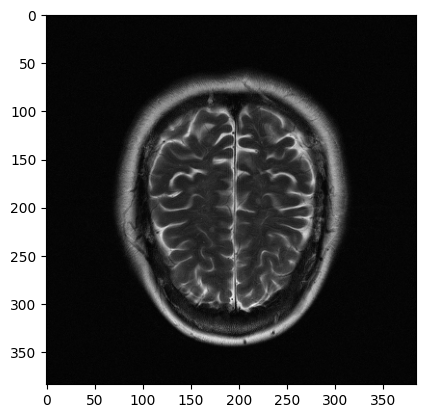

In [8]:
plt.imshow(target[0], cmap='gray')
plt.show()

In [9]:
mask = mask.cuda()
masked_kspace = masked_kspace.cuda()

with torch.no_grad():
    sens_map = model.sens_net(masked_kspace, mask)

tensor([[-2.4178],
        [-1.9907],
        [-3.5419],
        [-4.1864],
        [-3.2789],
        [-3.7338],
        [-7.9504],
        [-7.2168],
        [-2.9327],
        [-3.3370],
        [-6.2695],
        [-7.5275],
        [-7.5406],
        [-6.6347],
        [-7.8120],
        [-8.7131],
        [-2.2333],
        [-2.4660],
        [-4.2979],
        [-3.8096]], device='cuda:0') tensor([[ -6.9965],
        [ -5.6220],
        [-10.6095],
        [-12.6766],
        [ -9.7568],
        [-11.2087],
        [-24.6358],
        [-22.3123],
        [ -8.6555],
        [ -9.9613],
        [-19.2325],
        [-23.2414],
        [-23.3092],
        [-20.3885],
        [-24.1847],
        [-27.0518],
        [ -6.4042],
        [ -7.1693],
        [-13.0176],
        [-11.4395]], device='cuda:0') tensor([[11.1551],
        [ 9.0963],
        [16.7579],
        [20.0325],
        [15.4238],
        [17.6771],
        [38.8189],
        [35.1346],
        [13.6785],
        [15.6

In [10]:
lowres = fastmri.ifft2c(masked_kspace).cpu().numpy()

lowres_real = lowres[..., 0]
lowres_imag = lowres[..., 1]
lowres_theta = np.arctan2(lowres_imag, lowres_real)
lowres_abs = np.abs(lowres_real + 1j * lowres_imag)
lowres_ratio = lowres_real / lowres_imag

In [11]:
sens_map_real = sens_map[..., 0].cpu().numpy()
sens_map_imag = sens_map[..., 1].cpu().numpy()
sens_map_theta = np.arctan2(sens_map_imag, sens_map_real)
sens_map_abs = np.abs(sens_map_real + 1j * sens_map_imag)
sens_map_ratio = sens_map_real / sens_map_imag

In [12]:
def visualize(img, circular=False):
    kwargs = {'cmap': 'gray', 'vmin': -1, 'vmax': 1} if not circular else {
        'cmap': 'twilight', 'vmin': -np.pi, 'vmax': np.pi
    }

    img = fastmri.data.transforms.center_crop(img, (384, 384))
    img /= abs(img).max()

    if not circular and img.min() >= 0:
        kwargs['vmin'] = 0

    C = img.shape[0]
    T = int(np.sqrt(C))
    fig, axes = plt.subplots((C - 1) // T + 1, T, figsize=(12, 18))

    for c in range(C):
        axes[c//T, c%T].imshow(img[c], **kwargs)
        axes[c//T, c%T].set_title(f'Coil {c+1}')

    plt.tight_layout()
    plt.show()

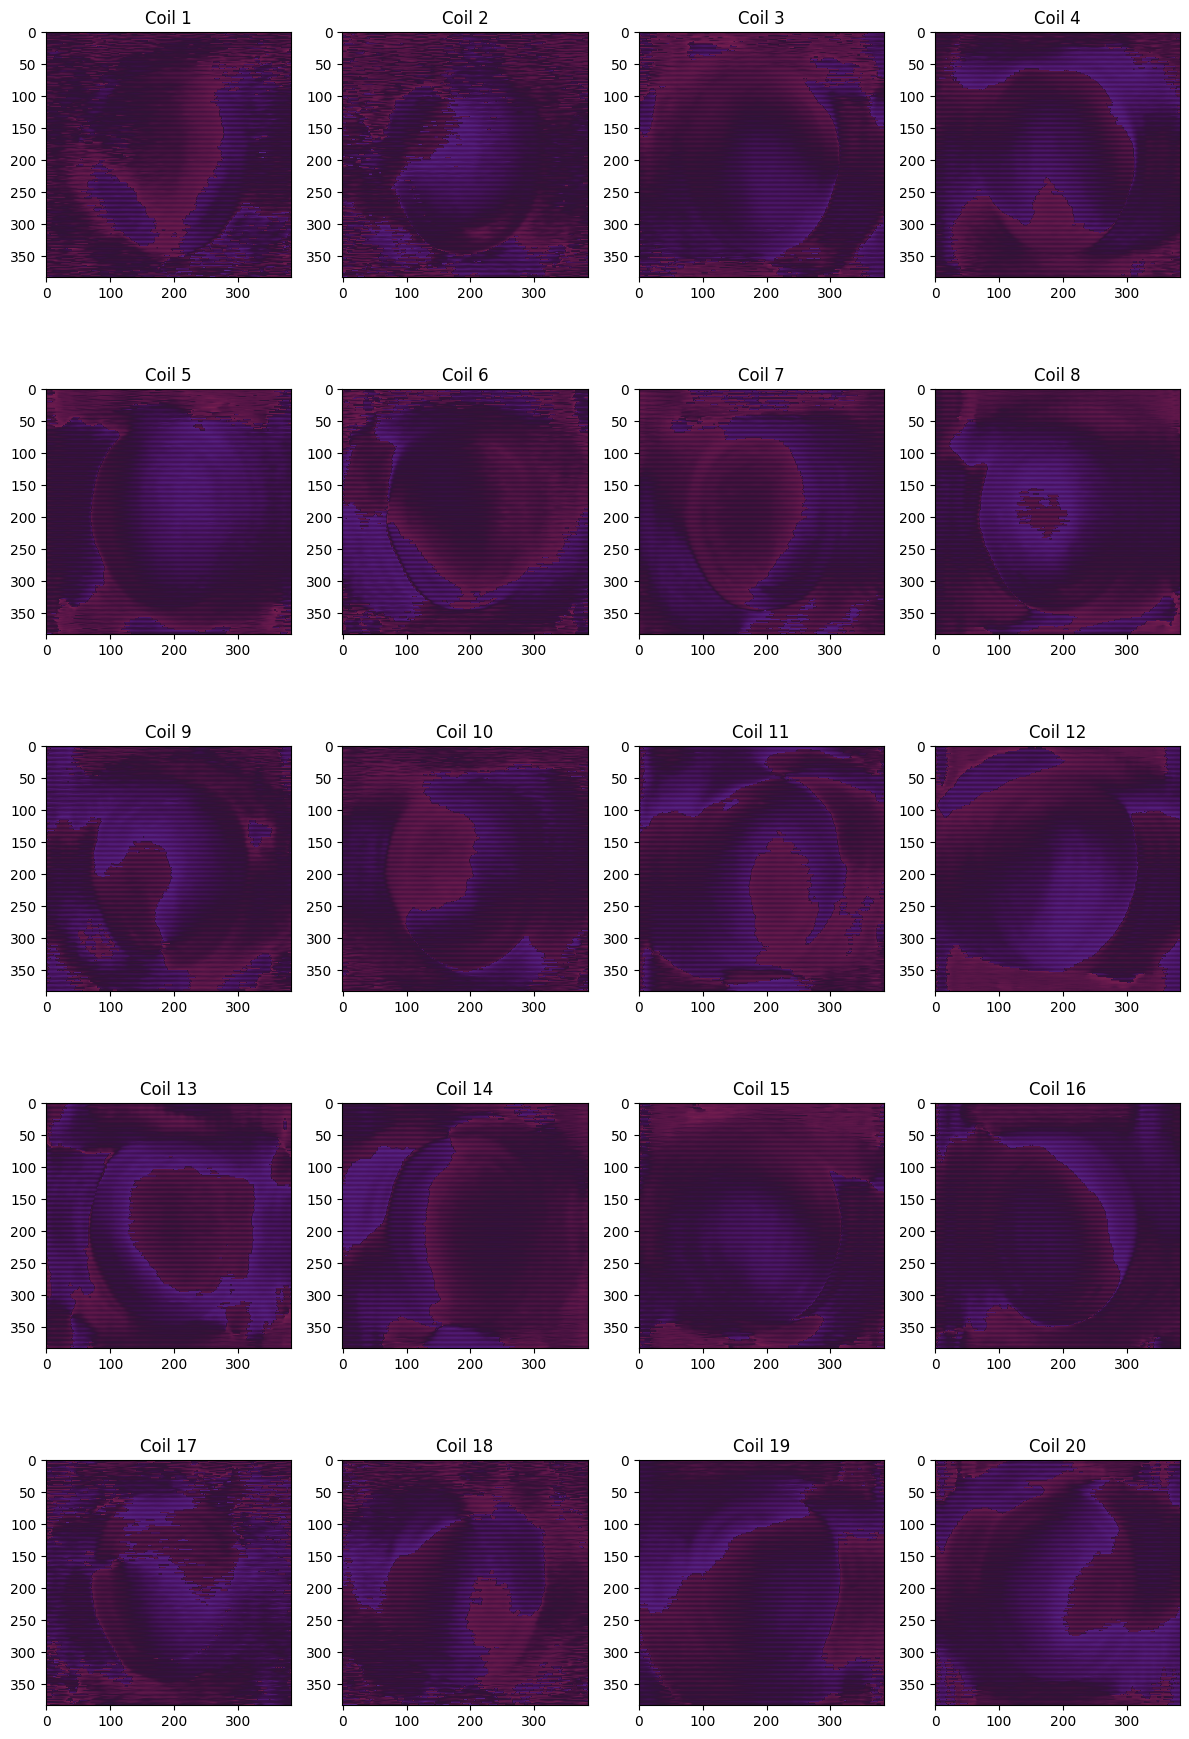

In [13]:
visualize(sens_map_theta[0], circular=True)

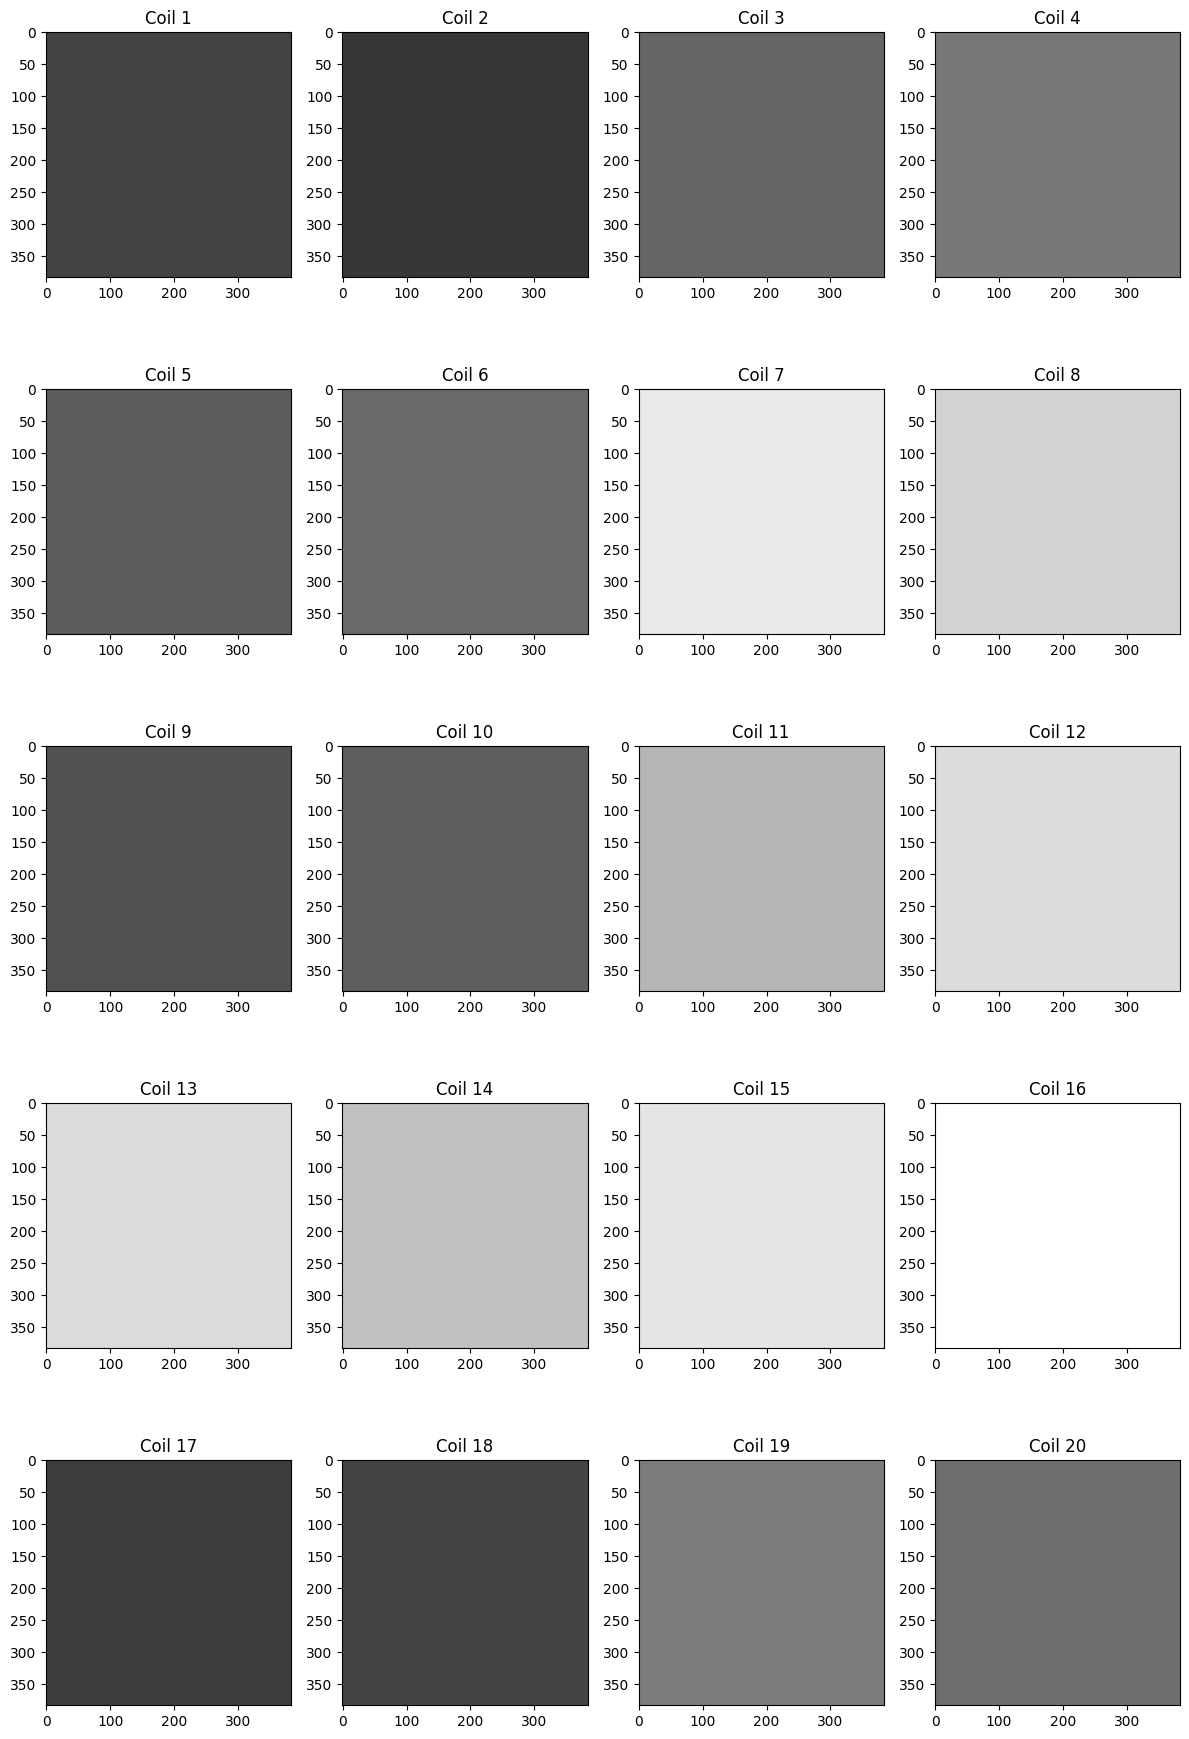

In [14]:
visualize(sens_map_abs[0])

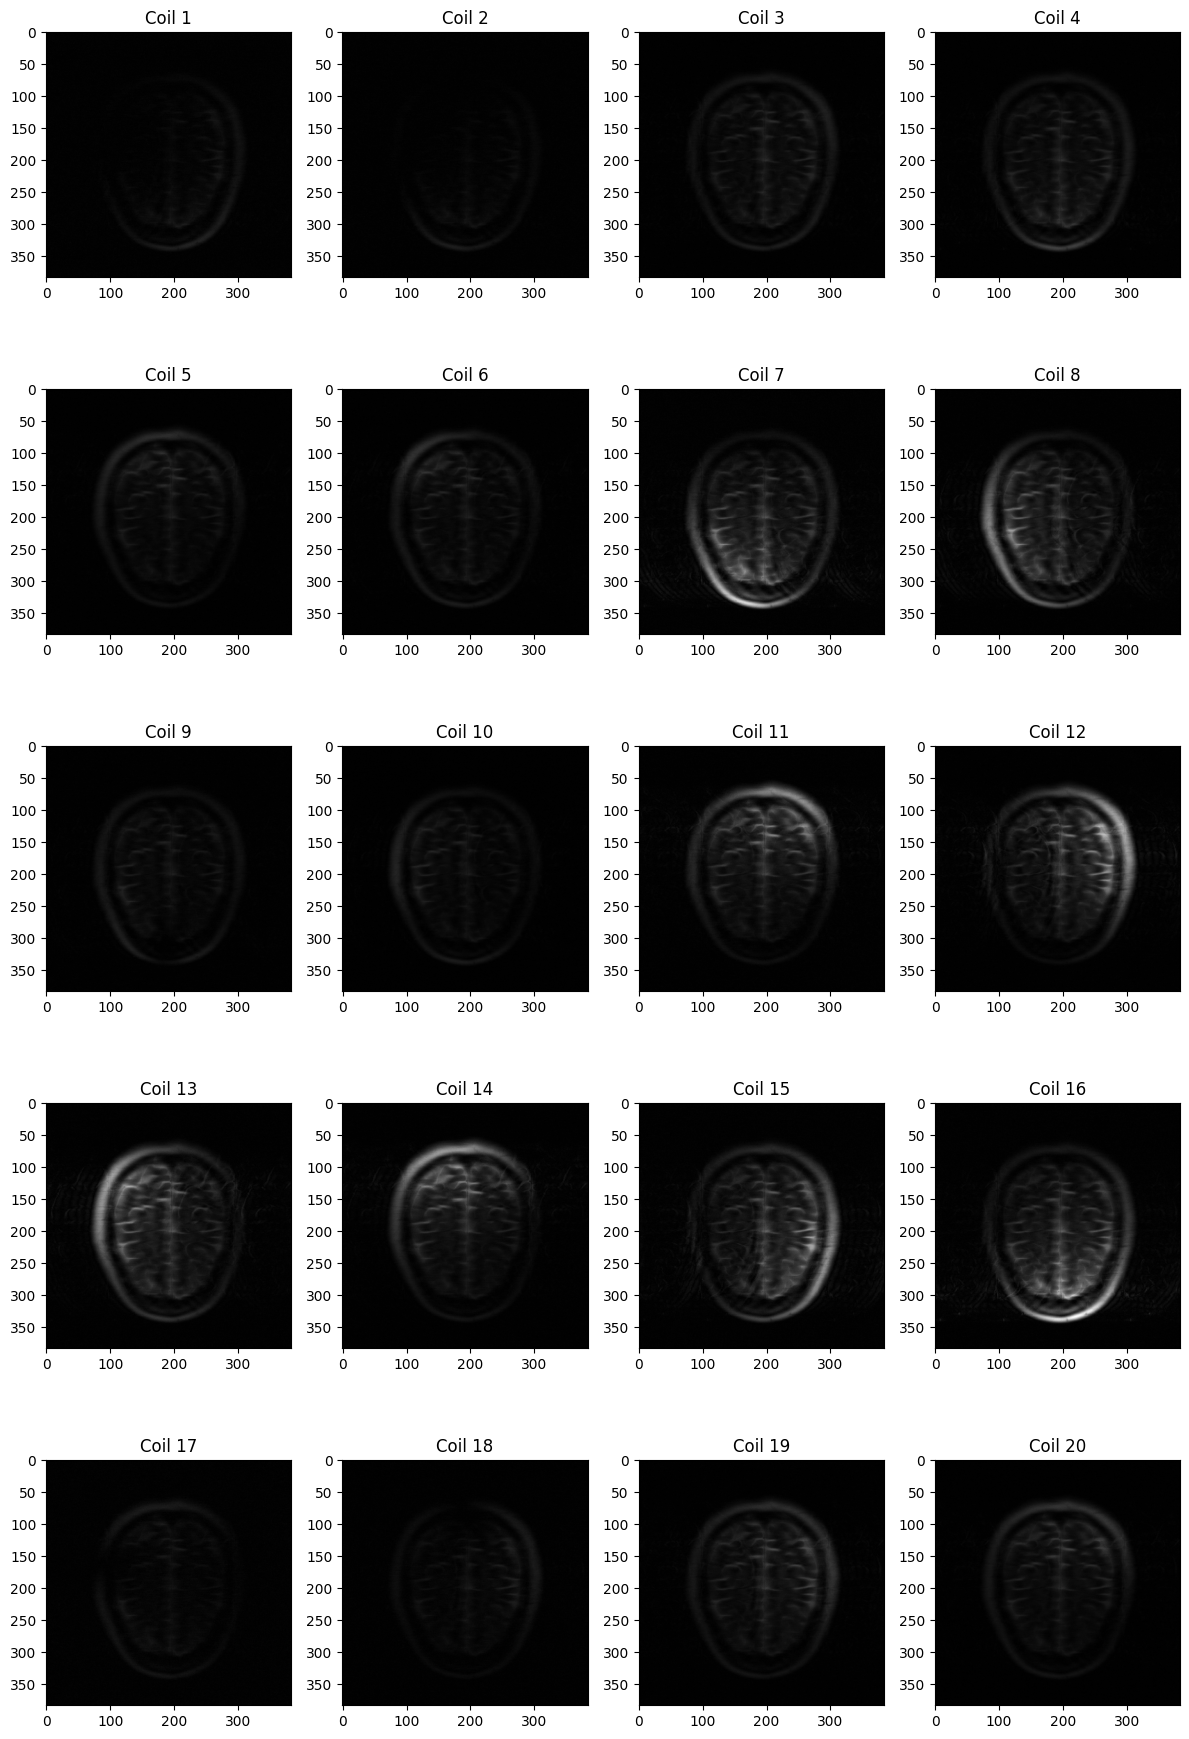

In [15]:
visualize(lowres_abs[0])

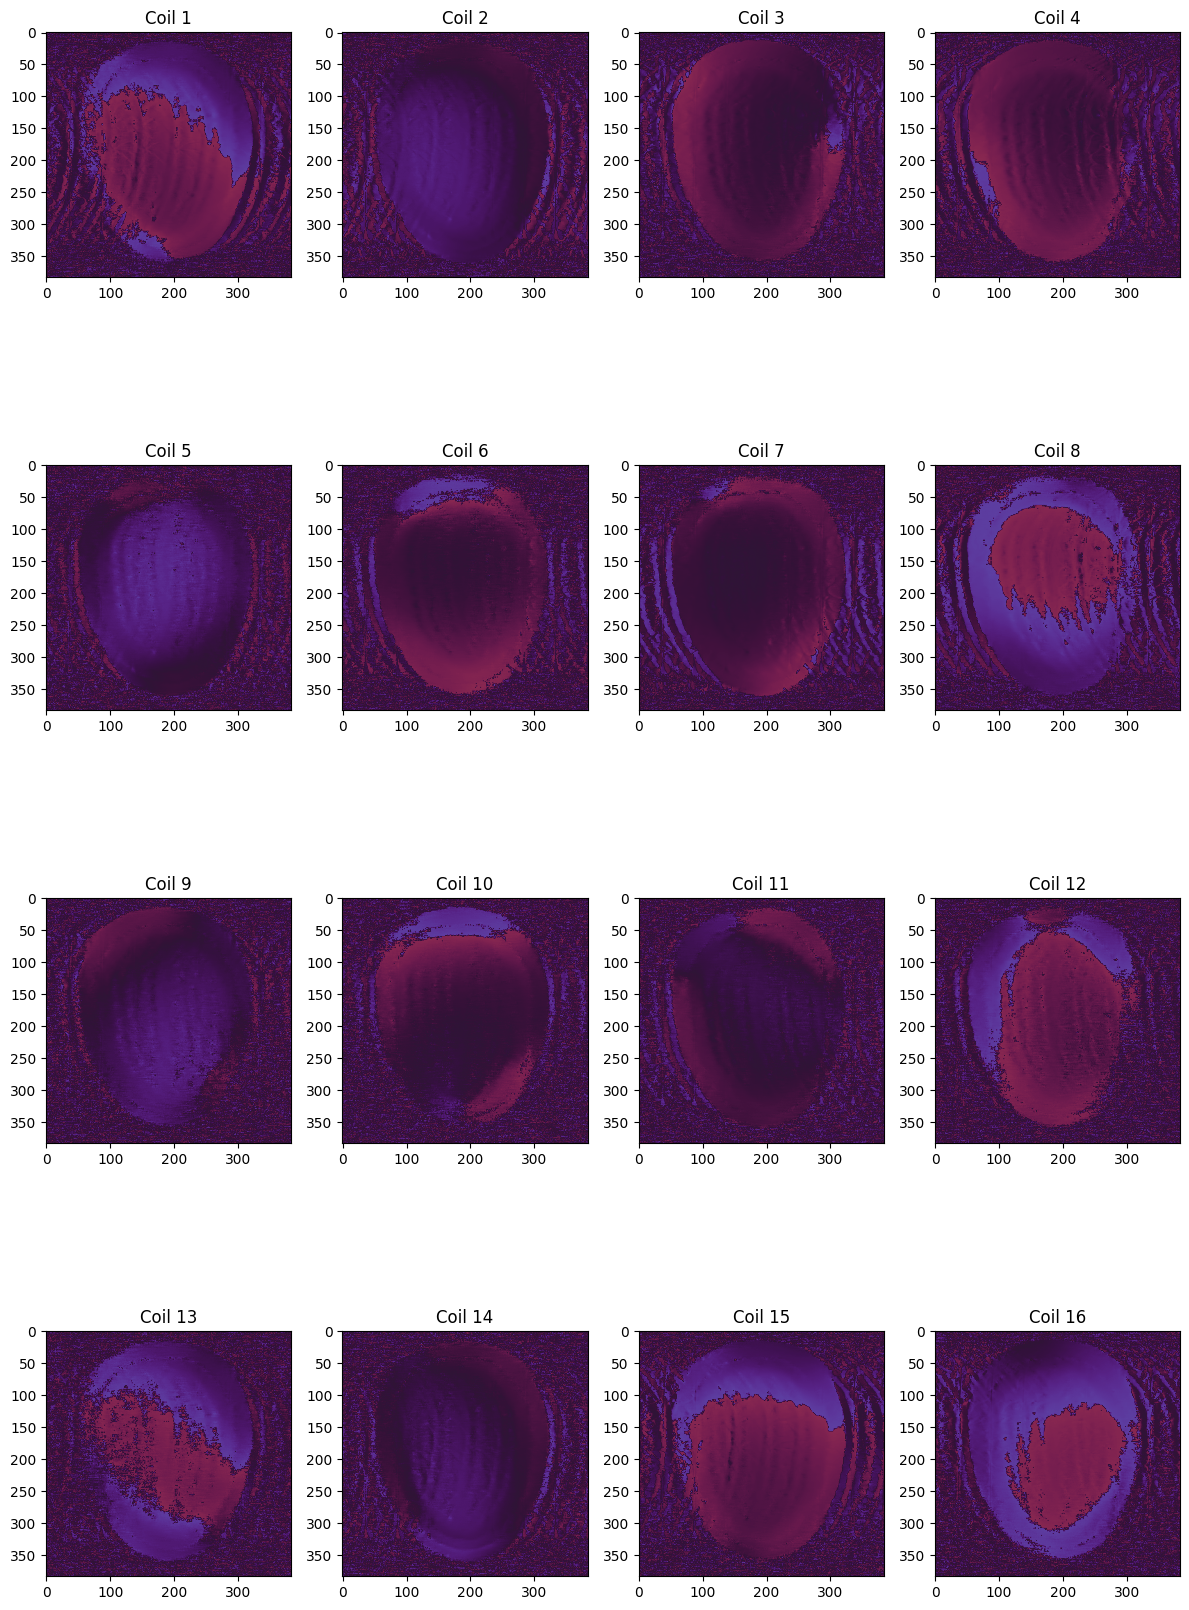

In [ ]:
visualize(lowres_theta[0], circular=True)